In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars

from pysindy.utils import lorenz, lorenz_control, enzyme
import pysindy as ps

# bad code but allows us to ignore warnings
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=ODEintWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import scipy.io as spio
import math
import os
import pykoopman as pk
from numpy import diff
from sklearn.metrics import mean_squared_error

C:\Users\ajoglek\AppData\Local\Temp\ipykernel_28460\2740610905.py:21: DeprecationWarning: Please use `ODEintWarning` from the `scipy.integrate` namespace, the `scipy.integrate.odepack` namespace is deprecated.
  from scipy.integrate.odepack import ODEintWarning


In [3]:
def plot_observables(observables, x, t, input_features=None, t_delay=None):
    '''Generate plots of state variables before and after being transformed into new observables.'''
    n_features = x.shape[1]
    if input_features is None:
        input_features = [f'x{i}' for i in range(n_features)]
    if t_delay is None:
        t_delay = t

    # Plot input features (state variables)
    fig, axs = plt.subplots(1, n_features, figsize=(n_features * 5, 3))

    for ax, k, feat_name in zip(axs, range(n_features), input_features):
        ax.plot(t, x[:, k])
        ax.set(xlabel='t', title=feat_name)
    fig.suptitle('Original state variables')
    fig.tight_layout()
    # fig.show()

    # Plot output features
    y = observables.fit_transform(x)

    n_output_features = observables.n_output_features_
    feature_names = observables.get_feature_names(input_features)

    n_rows = (n_output_features // 3) + (n_output_features % 3 > 0)
    fig, axs = plt.subplots(n_rows, 3, figsize=(15, 3 * n_rows), sharex=True)

    for ax, k, feat_name in zip(axs.flatten(), range(n_output_features), feature_names):
        ax.plot(t_delay, y[:, k])
        ax.set(xlabel='t', title=feat_name)

    fig.suptitle('Observables')
    fig.tight_layout()
    # fig.show()
    return

In [52]:
# Import data for training
dirname = os.getcwd()
# head, tail = dirname.split('Ajinkya_SINDy_tests')
dir = 'D:\pysindy\F1tenth_updated_filtered_data\Clean\Train'
X_train = []
X_dot_train = []
U_train = []
T_diff = []

from pysindy.differentiation import SmoothedFiniteDifference # Smoothen out the data
from pysindy.differentiation import SpectralDerivative
from pysindy.differentiation import FiniteDifference
sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 10})
fd = FiniteDifference()
sd = SpectralDerivative()

diff_method = fd

for file in os.listdir(dir):
    filename = os.path.join(dir,file)
    data = spio.loadmat(filename,squeeze_me=False)
    inputs = data['updated_data']['inputs'].item()
    inputs_ts = data['updated_data']['inputs_ts'].item()
    inputs_ts = np.reshape(inputs_ts,(np.shape(inputs_ts)[0],))
    states =  data['updated_data']['states'].item()
    states_ts = data['updated_data']['states_ts'].item()
    states_ts = np.reshape(states_ts,np.shape(states_ts)[0])
    states[:,2] = np.unwrap(states[:,2]) # Unwrapping the optitrack measured angle
    delta  = inputs[:,1]; delta[delta > 0] = np.pi/6; delta[delta < 0] = -np.pi/6 # Making the steering angle transition between -30 and 30 degrees
    inputs = np.column_stack((inputs,delta))

    #Use a common time difference for all observations
    t_diff = [states_ts[i+1] - states_ts[0] for i in range(len(states_ts)-1)]
    t_diff.insert(0,0)
    t_diff = np.array(t_diff)
    if t_diff.shape[0] > 45:
        x_dot = diff_method._differentiate(states[:,0],t_diff)
        y_dot = diff_method._differentiate(states[:,1],t_diff)
        theta_dot = diff_method._differentiate(states[:,2],t_diff)

        x_dot_train_ = np.column_stack((x_dot,y_dot,theta_dot))
        X_dot_train.append(x_dot_train_)
        x_train_ = np.column_stack((states[:,0],states[:,1],states[:,2]))
        X_train.append(x_train_)
        u_train_ = np.column_stack((inputs[:,0],inputs[:,1]))
        U_train.append(u_train_)
        T_diff.append(t_diff)

print(X_train[0].shape,U_train[0].shape,X_dot_train[0].shape)
print(len(T_diff))

(169, 3) (169, 2) (169, 3)
9


In [5]:
n_states = 3 # Number of states
n_inputs = 2 # Number of control inputs
dT = 0.1    # Timestep
n_traj = 9  # Number of trajectories
# n_int = 1000  # Integration length

[Text(0, 0.5, '$\\phi$'), Text(0.5, 0, '$t$')]

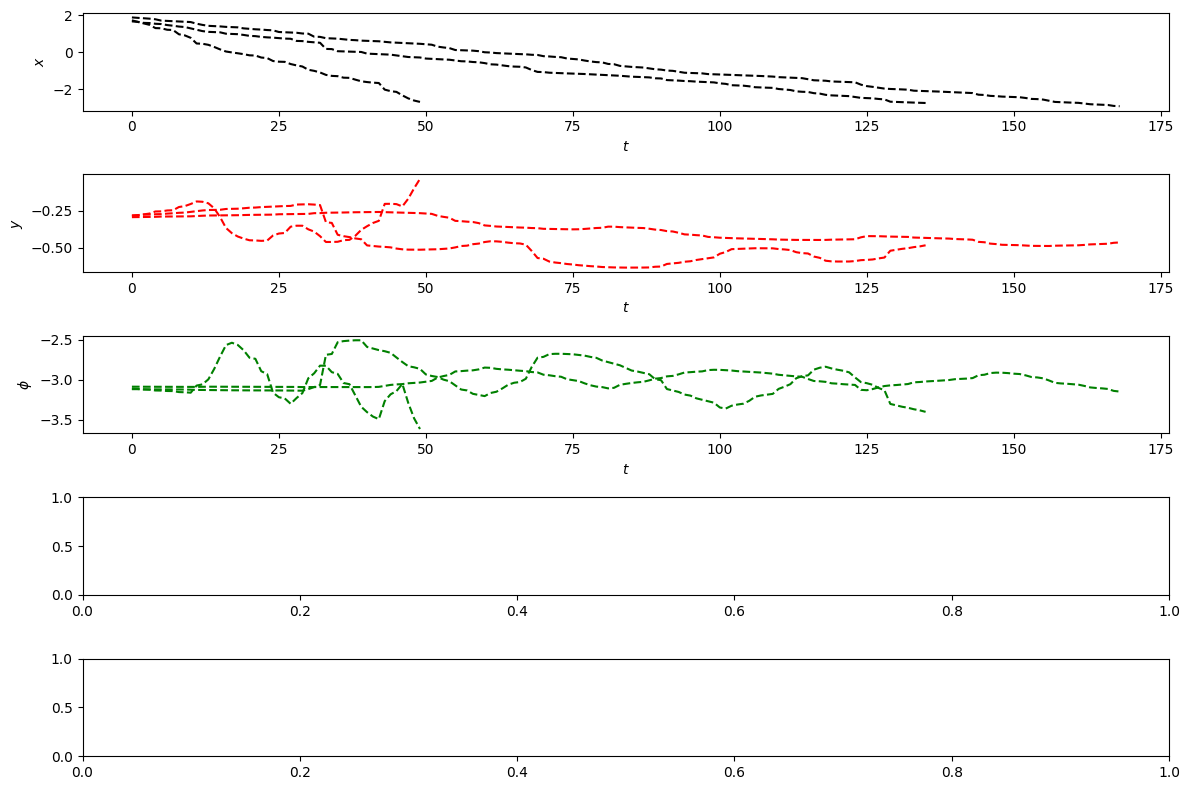

In [39]:
fig, axs = plt.subplots(5, 1, tight_layout=True, figsize=(12, 8))
for i in range(len(X_train) - 6):
    x = X_train[i][:,0]
    y = X_train[i][:,1]
    phi = X_train[i][:,2]
    vel = U_train[i][:,0]
    delta = U_train[i][:,1]
    axs[0].plot(x, '--k')
    axs[1].plot(y, '--r')
    axs[2].plot(phi, '--g')
    # axs[3].plot(vel, '-b')
    # axs[4].plot(delta, 'm')
axs[0].set(
        ylabel=r'$x$',
        xlabel=r'$t$')
axs[1].set(
        ylabel=r'$y$',
        xlabel=r'$t$')
axs[2].set(
        ylabel=r'$\phi$',
        xlabel=r'$t$')
# axs[3].set(
#         ylabel=r'$vel$',
#         xlabel=r'$t$')
# axs[4].set(
#         ylabel=r'$\omega$',
#         xlabel=r'$t$')

In [15]:
X0 = np.vstack(X_train).T
U0 = np.vstack(U_train).T
X = X0[:,:-1]
Y = X0[:,1:]

X_ = X_train[0].T
X_t = X_[:,:-1]
Y_t = X_[:,1:]
T_ = T_diff[0]


In [16]:
EDMDc = pk.regression.EDMDc()
RBF = pk.observables.RadialBasisFunction(rbf_type='thinplate', n_centers=10, centers=None, kernel_width=1.0, polyharmonic_coeff=1.0, include_states=True)

Polyfunc = pk.observables.Polynomial(degree=2)
RFF = pk.observables.RandomFourierFeatures(include_state=True,gamma=1.0,D=3)


observables = [lambda x: x ** 2, lambda x: 0 * x, lambda x, y: x * y]
observable_names = [
    lambda s: f"{s}^2",
    lambda s: str(0),
    lambda s, t: f"{s} {t}",
]

obs = pk.observables.CustomObservables(observables, observable_names=observable_names)


# Custom function from SINDy
feature_names = ['x','y','theta','v','delta']
# Initialize three libraries
poly_library = ps.PolynomialLibrary()
fourier_library = ps.FourierLibrary()
concat_library = poly_library+fourier_library
# library_functions = [lambda x,y: np.sin(x+y),lambda x,y: np.cos(x+y),lambda x,y,z: z*np.sin(x+y),lambda x,y,z: z*np.cos(x+y),lambda x,y: np.arctan2(y,x)]
library_functions = [lambda x,y: np.sin(x+y),lambda x,y: np.cos(x+y)]
library_function_names = [
    lambda x,y: "sin(" + x +"+" + y + ")",
    lambda x,y: "cos(" + x +"+" + y + ")",
    # lambda x,y,z: z +"*" + "sin(" + x +"+" + y + ")",
    # lambda x,y,z: z +"*" + "cos(" + x +"+" + y + ")",
    # lambda x,y: "atan2(" + y +"/" + x + ")"
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names
)

# Custom library version of pk observables
custom_obs = pk.observables.CustomObservables(library_functions, observable_names=library_function_names)
# End

# Initialize the default inputs, i.e. each library
# uses all the input variables, (5 inputs and 3 libraries here)
inputs_temp = np.tile([0, 1, 2, 3, 4], 3)
inputs_per_library = np.reshape(inputs_temp, (3, 5))


# Don't use the theta, delta, for  for generating the poly library
inputs_per_library[0, 0] = 3
inputs_per_library[0, 1] = 3
inputs_per_library[0, 2] = 3
inputs_per_library[0, 3] = 3
inputs_per_library[0, 4] = 3


# Don't use the x, y, v inputs for generating the Fourier library
inputs_per_library[1, 0] = 2
inputs_per_library[1, 1] = 2
inputs_per_library[1, 2] = 2
inputs_per_library[1, 3] = 2
inputs_per_library[1, 4] = 4

# Don't use the x, y, v inputs for generating the custom library
inputs_per_library[2, 0] = 2
inputs_per_library[2, 1] = 2
inputs_per_library[2, 2] = 2
inputs_per_library[2, 3] = 2
inputs_per_library[2, 4] = 4
# print(inputs_per_library)

# Tensor all the polynomial and Fourier library terms together
# and tensor all the Fourier and Custom library terms together.
tensor_array = [[1, 1, 0], [1,0,1]]

# Initialize this generalized library, all the work hidden from the user!
generalized_library = ps.GeneralizedLibrary(
    [poly_library, fourier_library, custom_library],
    tensor_array=tensor_array,
    inputs_per_library=inputs_per_library,
)
#End of custom function

model = pk.Koopman(observables=custom_obs, regressor=EDMDc)
model.fit(X.T, y=Y.T, u=U0.T)
print(model.observables)

CustomObservables(observable_names=[<function identity_name at 0x000001ECFFF03C70>,
                                    <function <lambda> at 0x000001ECA2C78670>,
                                    <function <lambda> at 0x000001ECA2C785E0>],
                  observables=[<function identity at 0x000001ECFFF02F80>,
                               <function <lambda> at 0x000001ECA2C781F0>,
                               <function <lambda> at 0x000001ECA2C78550>])


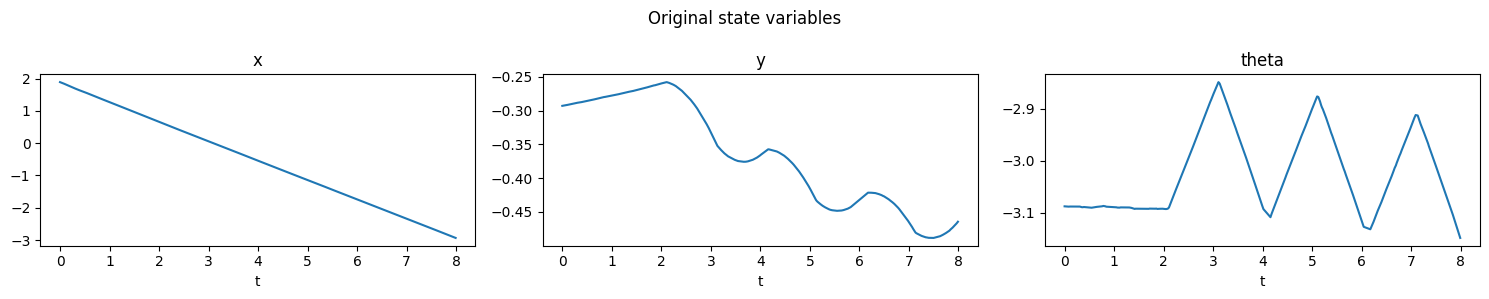

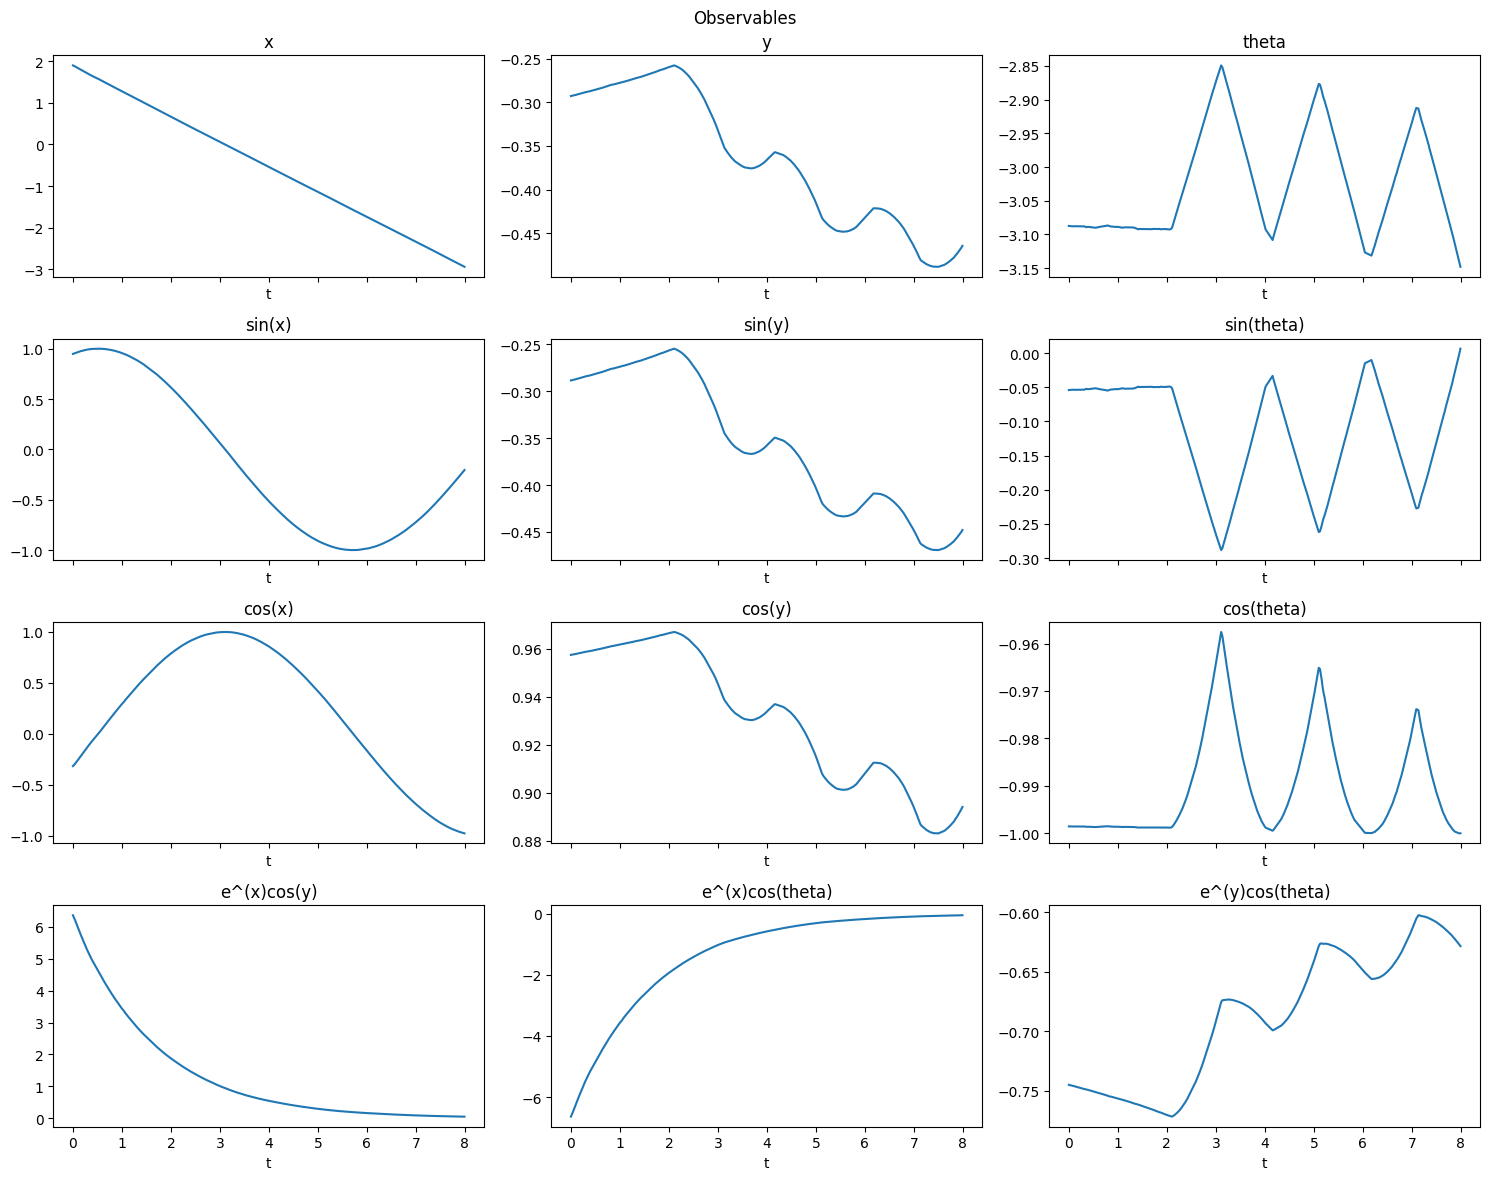

In [42]:
# first observable: from Polynomial combinations
ob1 = pk.observables.Polynomial(degree=2)

# second observable: from CustomObservables of univariate functions
observables = [lambda x: np.sin(x), lambda x: np.cos(x), lambda x, y: np.exp(x)*np.cos(y)]
observable_names = [
    lambda s: f"sin({s})",
    lambda s: f"cos({s})",
    lambda s, t: f"e^({s})cos({t})",
]
ob2 = pk.observables.CustomObservables(observables, observable_names=observable_names)

# # fourth observable: random fourier feature without state
# ob3 = pk.observables.RandomFourierFeatures(include_state=False,gamma=0.01,D=2)
#
# # fifth observable: random fourier feature with state
# ob4 = pk.observables.RandomFourierFeatures(include_state=True,gamma=0.1,D=3)
#
# # Adding radial basis function
# ob5 = pk.observables.RadialBasisFunction(rbf_type='thinplate', centers=None, kernel_width=1.0, polyharmonic_coeff=1.0, include_states=True)
#
#
#
#
# obs = ob1 + ob2 + ob5
# input_features = ["x", "y","phi"]
plt_obs = ob2
# print("The input features $x$ , $y$, $\phi$ are listed as x0, x1,x2")
plot_observables(plt_obs, X_.T,T_,input_features=["x","y","theta"])
#
# model = pk.Koopman(observables=custom_obs, regressor=EDMDc)
# model.fit(X.T, y=Y.T, u=U0.T,dt=0.016)


In [45]:
# Multi-step prediction with Koopman/EDMDc model
# print(U_train[0][:,np.newaxis].shape)
num = 2
Xkoop = model.simulate(X_train[num][0,:][np.newaxis,:], U_train[num][:,np.newaxis],n_steps=U_train[num].shape[0] - 1)
print(Xkoop.shape)
Xkoop = np.vstack([X_train[num][0,:][np.newaxis,:], Xkoop]) # add initial condition to simulated data for comparison below
print(Xkoop.shape)

(49, 3)
(50, 3)


[Text(0, 0.5, '$x_2$'), Text(0.5, 0, '$t$')]

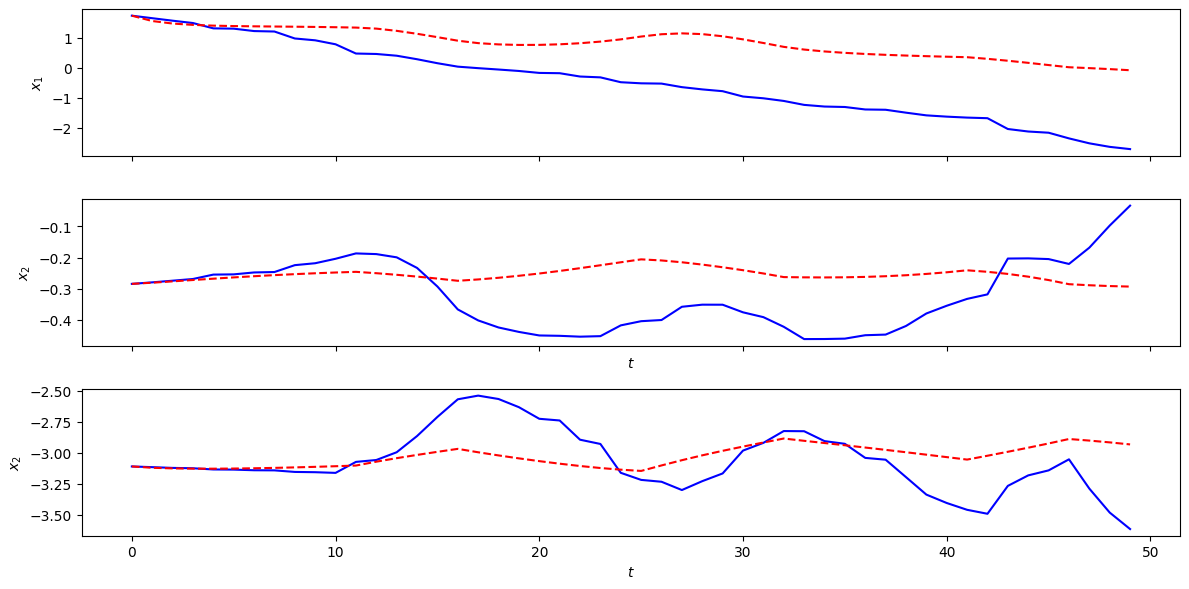

In [46]:
fig, axs = plt.subplots(3, 1, sharex=True, tight_layout=True, figsize=(12, 6))
# axs[0].plot( u, '-k')
# axs[0].set(ylabel=r'$u$')
axs[0].plot(X_train[num][:,0], '-', color='b', label='True')
axs[0].plot(Xkoop[:,0], '--r', label='EDMDc')
axs[0].set(ylabel=r'$x_1$')
axs[1].plot(X_train[num][:,1], '-', color='b', label='True')
axs[1].plot(Xkoop[:,1], '--r', label='EDMDc')
axs[1].set(
        ylabel=r'$x_2$',
        xlabel=r'$t$')
axs[2].plot(X_train[num][:,2], '-', color='b', label='True')
axs[2].plot(Xkoop[:,2], '--r', label='EDMDc')
axs[2].set(
        ylabel=r'$x_2$',
        xlabel=r'$t$')